<a href="https://colab.research.google.com/github/kundajelab/tfmodisco/blob/master/examples/simulated_TAL_GATA_deeplearning/TF_MoDISco_TAL_GATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF-MoDISco on the TAL GATA simulation

### Note: we are still refining the multi-task version of TF-MoDISco. If you encounter difficulties running TF-MoDISco with multiple tasks, our recommendation is to run it on one task at a time.

This notebook demonstrates running TF-MoDISco on importance scores obtained from the TAL-GATA simulation used in the DeepLIFT paper. See Generate Importance Scores.ipynb for a notebook demonstrating how to produce the scores. There are 3 tasks. Task 0 is positive when both TAL and GATA motifs are present in the sequence. Task 1 is positive when GATA motifs are present in the sequence. Task 2 is positive when TAL motifs are present in the sequence.

In [1]:
!pip install modisco

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [3]:
#this is needed when running in google colab to specify that version 1.x of tensorflow must
# be used; it just throws an error if run in a regular jupyter notebook.
%tensorflow_version 1.x 

UsageError: Line magic function `%tensorflow_version` not found.


In [2]:
import numpy as np
import modisco
import sys
import os

TF-MoDISco is using the TensorFlow backend.
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/a

## Grab the input data

In [5]:
#grab scores for tfmodisco
#!/usr/bin/env bash
![[ -f scores.h5 ]] || curl -o scores.h5 https://raw.githubusercontent.com/AvantiShri/model_storage/23d8f3ffc89af210f6f0bf7e65585eff259ba672/modisco/scores.h5
![[ -f sequences.simdata.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
![[ -f test.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

## Functions for one-hot encoding sequences¶

In [6]:
#Functions for one-hot encoding sequences
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [7]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
n = 100 #since this is just a test run, for speed I am limiting to 100 sequences
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) for x in f['contrib_scores'][task][:n]]
    task_to_hyp_scores[task] = [np.array(x) for x in f['hyp_contrib_scores'][task][:n]]

onehot_data = [one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences][:n]

Double check by plotting

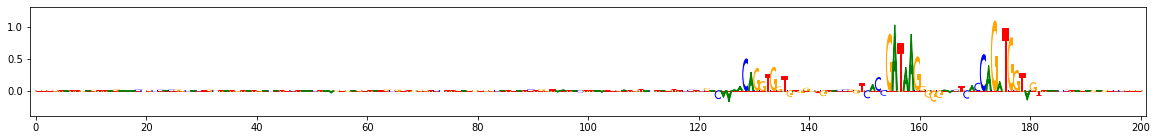

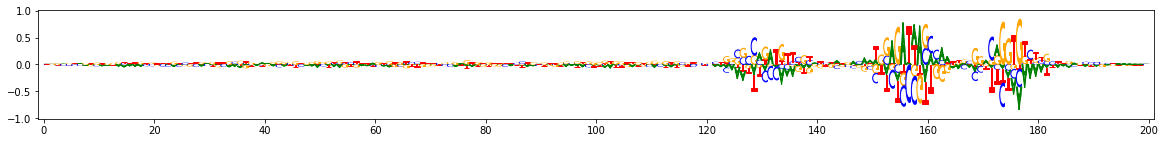

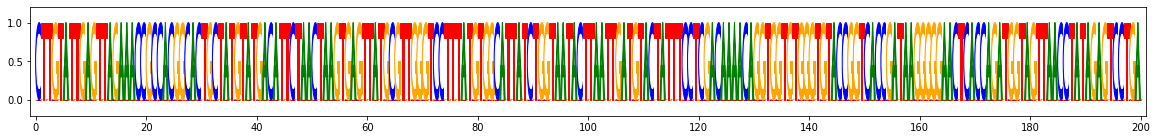

In [8]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=20)

Run TF-MoDISco
TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there are 3 tasks, there are 27 possible metaclusters (consisting of a +1, -1 or 0 for each task). Consistent with the simulation, the [+1, +1, 0], [+1, 0, +1], [0, 0, +1] and [0, +1, 0] metaclusters turn up motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:

- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central trim_to_window_size bp with the highest importance. trim_to_window_size is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by initial_flank_to_add. This is set to 3 rather than the default of 10.
- The final_min_cluster_size is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 60 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, which tends to run out of memory on many systems (I would change the default but want to avoid breaking reproducibility for older users)
- target_seqlet_fdr controls the noisiness of the seqlets. For a particular task, "significant" seqlets are identified by first smoothing importance scores with a window of size sliding_window_size and then fitting a laplace distribution to the left and right tails. This laplace distribution is assumed to represent the null distribution of window importance scores (note: as an alternative, it's possible to supply an empirical null distribution; see examples/H1ESC_Nanog_gkmsvm/TF MoDISco Nanog.ipynb for an example). A threshold is then identified such that the false discovery rate (computed as the ratio of the expected fraction of windows with a certain score in the null distribution relative to the observed fraction of windows with that score) is less that target_seqlet_fdr. Note: if the number of sliding windows that pass the FDR threshold is smaller than min_passing_windows_frac (default value 0.03 at the time of writing) or larger than max_passing_windows_frac (default value of 0.2 at the time of writing), the threshold will be adjusted.

MEMORY 0.270544896
On task task0
Computing windowed sums on original
Generating null dist
Computing threshold
Thresholds from null dist were -inf  and  35.08974833509393
Passing windows frac was 0.23865591397849462 , which is above  0.2 ; adjusting
Final raw thresholds are -52.08948386962456  and  52.08948386962456
Final transformed thresholds are -0.8  and  0.8


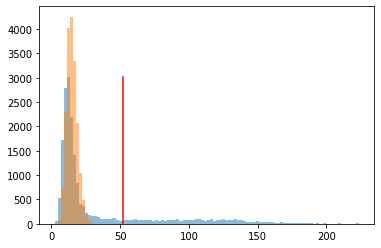

Got 225 coords
On task task1
Computing windowed sums on original
Generating null dist
Computing threshold
Thresholds from null dist were -inf  and  35.076043193568324
Final raw thresholds are -inf  and  35.076043193568324
Final transformed thresholds are -1.0  and  0.8246236559139785


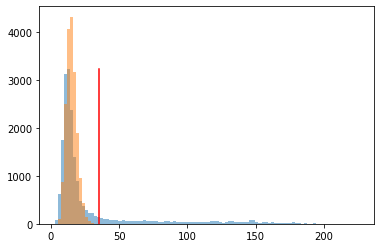

Got 240 coords
On task task2
Computing windowed sums on original
Generating null dist
Computing threshold
Thresholds from null dist were -inf  and  35.07046215664957
Final raw thresholds are -inf  and  35.07046215664957
Final transformed thresholds are -1.0  and  0.8344623655913979


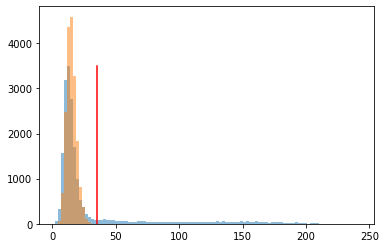

Got 224 coords
After resolving overlaps, got 389 seqlets
Across all tasks, the weakest transformed threshold used was: 0.7999
MEMORY 0.286920704
389 identified in total
Reducing weak_threshold_for_counting_sign to match weakest_transformed_thresh, from 0.8 to 0.7999
2 activity patterns with support >= 100 out of 26 possible patterns
Metacluster sizes:  [116, 107]
Idx to activities:  {0: '1,0,1', 1: '1,1,0'}
MEMORY 0.286928896
On metacluster 1
Metacluster size 107
Relevant tasks:  ('task0', 'task1')
Relevant signs:  (1, 1)

TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 107
(Round 1) Computing coarse affmat
MEMORY 0.290586624
Beginning embedding computation
Computing embeddings






Using TensorFlow backend.


Finished embedding computation in 0.25 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.01 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.01 s
(Round 1) Compute nearest neighbors from coarse affmat
MEMORY 0.308158464
Computed nearest neighbors in 0.0 s
MEMORY 0.308166656
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 0.308170752
Launching nearest neighbors affmat calculation job
MEMORY 0.309264384
Parallel runs completed
MEMORY 0.313122816
Job completed in: 0.42 s
MEMORY 0.313126912
Launching nearest neighbors affmat calculation job
MEMORY 0.313020416
Parallel runs completed
MEMORY 0.313151488
Job completed in: 0.51 s
MEMORY 0.313151488
(Round 1) Computed affinity matrix on nearest neighbors in 0.98 s
MEMORY 0.311394304
Filtered down to 101 of 107
(Round 1) Retained 101 rows out of 107 after filtering
MEMORY 0.311590912
(Round 1) Computing de

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.37536736592220915
Quality: 0.3762684745179274


 18%|█▊        | 9/50 [00:00<00:00, 89.75it/s]

Quality: 0.37715633351115946


100%|██████████| 50/50 [00:00<00:00, 84.48it/s]

Got 7 clusters after round 1
Counts:
{6: 2, 5: 5, 0: 26, 2: 20, 1: 20, 3: 15, 4: 13}
MEMORY 0.307380224
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.307380224
Aggregating for cluster 0 with 26 seqlets
MEMORY 0.307380224


Trimmed 4 out of 26
Aggregating for cluster 1 with 20 seqlets
MEMORY 0.307576832
Trimmed 0 out of 20
Skipped 2 seqlets
Aggregating for cluster 2 with 20 seqlets
MEMORY 0.307625984
Trimmed 0 out of 20
Skipped 2 seqlets
Aggregating for cluster 3 with 15 seqlets
MEMORY 0.307806208
Trimmed 0 out of 15
Skipped 3 seqlets
Aggregating for cluster 4 with 13 seqlets
MEMORY 0.30785536
Trimmed 0 out of 13
Skipped 2 seqlets
Aggregating for cluster 5 with 5 seqlets
MEMORY 0.30785536
Trimmed 0 out of 5
Aggregating for cluster 6 with 2 seqlets
MEMORY 0.30789632
Trimmed 0 out of 2
(Round 2) num seqlets: 88
(Round 2) Computing coarse affmat
MEMORY 0.307920896
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.08 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.01 s
(Round 2) Compute nearest 

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.3477068055464451
Quality: 0.34921299474188106
Quality: 0.35012255764337313


 38%|███▊      | 19/50 [00:00<00:00, 94.03it/s]

Quality: 0.3505921930497653


100%|██████████| 50/50 [00:00<00:00, 94.72it/s]

Got 6 clusters after round 2
Counts:
{3: 16, 0: 19, 2: 16, 1: 18, 4: 11, 5: 8}
MEMORY 0.308457472
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.308457472
Aggregating for cluster 0 with 19 seqlets
MEMORY 0.308457472
Trimmed 6 out of 19
Aggregating for cluster 1 with 18 seqlets
MEMORY 0.308457472


Trimmed 0 out of 18
Aggregating for cluster 2 with 16 seqlets
MEMORY 0.308527104
Trimmed 3 out of 16
Aggregating for cluster 3 with 16 seqlets
MEMORY 0.308559872
Trimmed 0 out of 16
Aggregating for cluster 4 with 11 seqlets
MEMORY 0.308559872
Trimmed 1 out of 11
Aggregating for cluster 5 with 8 seqlets
MEMORY 0.308559872
Trimmed 2 out of 8
Got 6 clusters
Splitting into subclusters...
MEMORY 0.308568064
Merging on 6 clusters
MEMORY 0.308568064
On merging iteration 1
Computing pattern to seqlet distances
Computing pattern to pattern distances
Collapsing 0 & 3 with prob 4.352502474356351e-05 and sim 1.9573482553509005
Collapsing 1 & 2 with prob 4.211356355340369e-05 and sim 1.9149449544625463
Collapsing 0 & 1 with prob 1.4937245603643149e-05 and sim 1.9135443546973738
Collapsing 0 & 2 with prob 1.3196530282600043e-05 and sim 1.9109517506680078
Collapsing 1 & 3 with prob 4.354458860330195e-05 and sim 1.9031429690374813
Collapsing 2 & 3 with prob 6.0954112836145774e-05 and sim 1.89238837307

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.45742985840845596


100%|██████████| 50/50 [00:00<00:00, 77.03it/s]

Got 8 clusters after round 1
Counts:
{3: 15, 2: 21, 6: 4, 1: 23, 4: 12, 0: 24, 5: 9, 7: 3}
MEMORY 0.312324096
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.312324096
Aggregating for cluster 0 with 24 seqlets
MEMORY 0.312324096
Trimmed 4 out of 24
Skipped 3 seqlets


Aggregating for cluster 1 with 23 seqlets
MEMORY 0.312324096
Trimmed 3 out of 23
Skipped 2 seqlets
Aggregating for cluster 2 with 21 seqlets
MEMORY 0.312324096
Trimmed 1 out of 21
Skipped 3 seqlets
Aggregating for cluster 3 with 15 seqlets
MEMORY 0.31234048
Trimmed 0 out of 15
Skipped 2 seqlets
Aggregating for cluster 4 with 12 seqlets
MEMORY 0.31234048
Trimmed 0 out of 12
Skipped 1 seqlets
Aggregating for cluster 5 with 9 seqlets
MEMORY 0.312406016
Trimmed 0 out of 9
Skipped 2 seqlets
Aggregating for cluster 6 with 4 seqlets
MEMORY 0.312406016
Trimmed 0 out of 4
Aggregating for cluster 7 with 3 seqlets
MEMORY 0.312406016
Trimmed 0 out of 3
(Round 2) num seqlets: 90
(Round 2) Computing coarse affmat
MEMORY 0.312406016
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.08 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.4237724973552611
Quality: 0.4248220988516217
Quality: 0.42528218204247625


 20%|██        | 10/50 [00:00<00:00, 96.93it/s]

Quality: 0.4262534746547396


100%|██████████| 50/50 [00:00<00:00, 106.91it/s]

Got 6 clusters after round 2
Counts:
{0: 23, 1: 19, 5: 9, 2: 16, 4: 9, 3: 14}
MEMORY 0.315834368
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.315834368
Aggregating for cluster 0 with 23 seqlets
MEMORY 0.315834368


Trimmed 0 out of 23
Aggregating for cluster 1 with 19 seqlets
MEMORY 0.315834368
Trimmed 0 out of 19
Aggregating for cluster 2 with 16 seqlets
MEMORY 0.315834368
Trimmed 0 out of 16
Aggregating for cluster 3 with 14 seqlets
MEMORY 0.31584256
Trimmed 0 out of 14
Aggregating for cluster 4 with 9 seqlets
MEMORY 0.31584256
Trimmed 1 out of 9
Aggregating for cluster 5 with 9 seqlets
MEMORY 0.31584256
Trimmed 0 out of 9
Got 6 clusters
Splitting into subclusters...
MEMORY 0.315875328
Merging on 6 clusters
MEMORY 0.315875328
On merging iteration 1
Computing pattern to seqlet distances
Computing pattern to pattern distances
Collapsing 1 & 4 with prob 6.739918507313682e-06 and sim 1.953303854676359
Collapsing 1 & 5 with prob 8.692330541035318e-05 and sim 1.9427325676897158
Collapsing 0 & 1 with prob 0.0002728550460103236 and sim 1.9394206431393095
Collapsing 1 & 2 with prob 0.00010486621985174133 and sim 1.938519459789721
Collapsing 2 & 3 with prob 1.0697677149259624e-05 and sim 1.93481215803412

In [9]:
import h5py
import numpy as np
%matplotlib inline
import modisco

from importlib import reload
import h5py
import numpy as np
import modisco
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.phenograph
reload(modisco.cluster.phenograph)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.cluster
reload(modisco.cluster)
import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.affinitymat.transformers
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

from collections import OrderedDict

null_per_pos_scores = modisco.coordproducers.LogPercentileGammaNullDist(num_to_samp=20000)
task_names = ["task0", "task1", "task2"]
per_position_contrib_scores = OrderedDict([                         
    (x, modisco.coordproducers.per_sequence_zscore_log_percentile_transform(
        #max_num_to_use_for_percentile=20000,
        score_track=[np.sum(s,axis=1) for s in task_to_scores[x]]))             
    for x in task_names])

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.01,
                    min_passing_windows_frac=0.03,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        #Note: as of version 0.5.6.0, it's possible to use the results of a motif discovery
                        # software like MEME to improve the TF-MoDISco clustering. To use the meme-based
                        # initialization, you would specify the initclusterer_factory as shown in the
                        # commented-out code below:
                        #initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                        #    meme_command="meme", base_outdir="meme_out",            
                        #    max_num_seqlets_to_use=10000, nmotifs=10, n_jobs=1),
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=30)
                )(
                 task_names=task_names,
                 contrib_scores=task_to_scores,
                 hypothetical_contribs=task_to_hyp_scores,
                 one_hot=onehot_data,
                 per_position_contrib_scores=per_position_contrib_scores,
                 null_per_pos_scores = null_per_pos_scores)

## Save Results

In [10]:
import h5py
import modisco.util
reload(modisco.util)
![[ -e results.hdf5 ]] && rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)
grp.close()

## Print results directly from hdf5

Metaclusters heatmap


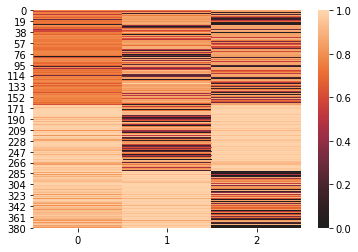

metacluster_0
activity pattern: [1 0 1]
metacluster_0 pattern_0
total seqlets: 72
Task 0 hypothetical scores:


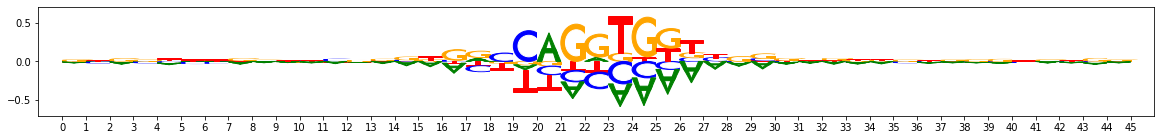

Task 0 actual importance scores:


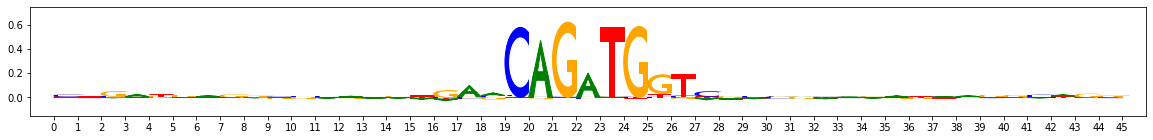

Task 1 hypothetical scores:


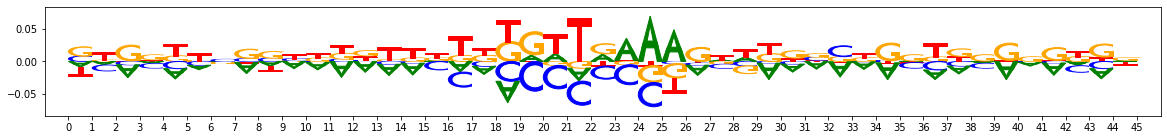

Task 1 actual importance scores:


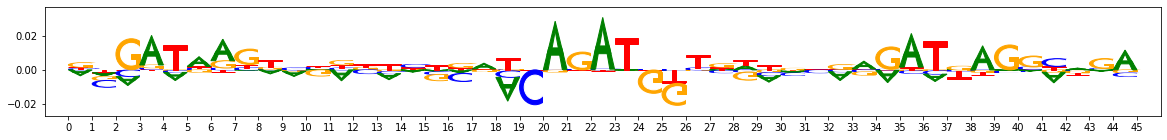

Task 2 hypothetical scores:


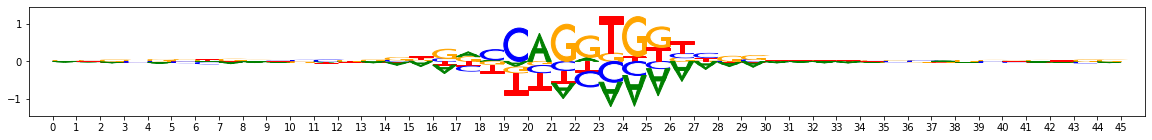

Task 2 actual importance scores:


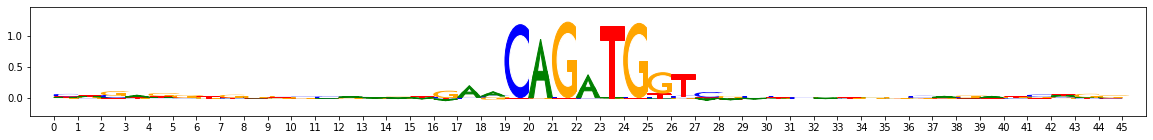

onehot, fwd and rev:


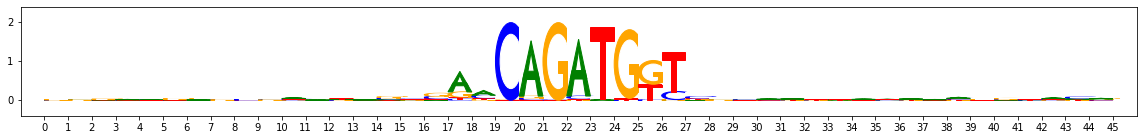

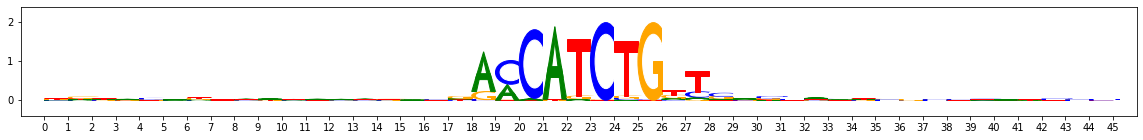

metacluster_1
activity pattern: [1 1 0]
metacluster_1 pattern_0
total seqlets: 69
Task 0 hypothetical scores:


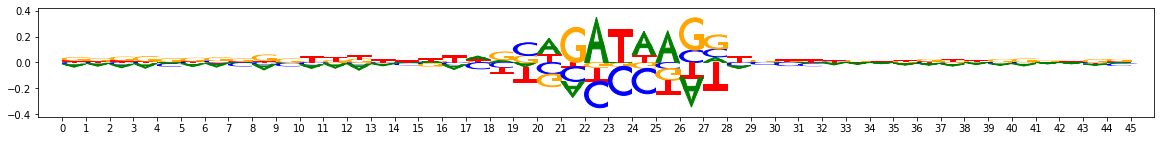

Task 0 actual importance scores:


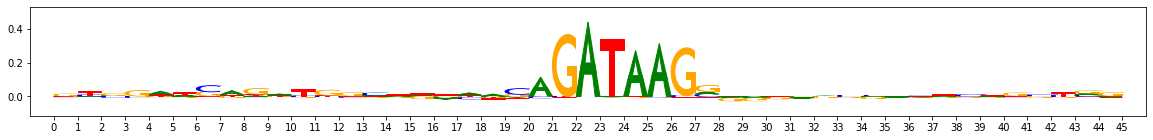

Task 1 hypothetical scores:


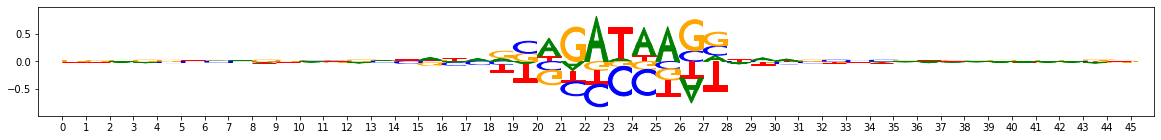

Task 1 actual importance scores:


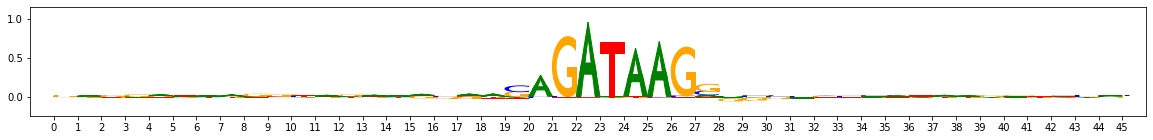

Task 2 hypothetical scores:


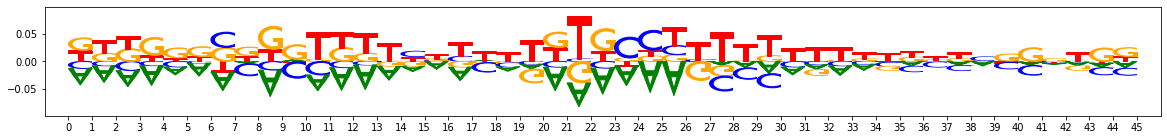

Task 2 actual importance scores:


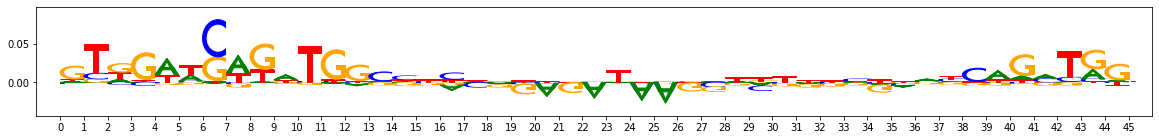

onehot, fwd and rev:


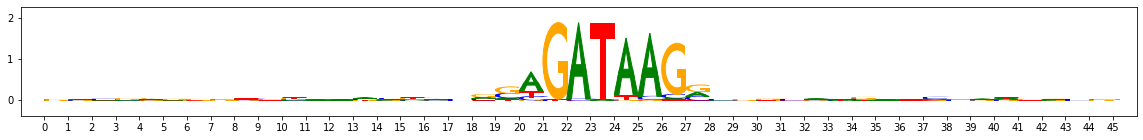

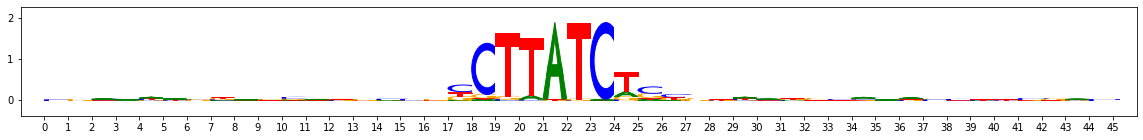

In [11]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.array([0.27, 0.23, 0.23, 0.27])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("Task 1 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        print("Task 1 actual importance scores:")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        print("Task 2 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        print("Task 2 actual importance scores:")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()

## Load the saved hdf5 file
Load the results object from the saved file

In [13]:
import h5py
import numpy as np
import modisco
from modisco.tfmodisco_workflow import workflow

track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=tasks,
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

grp = h5py.File("results.hdf5","r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

In [22]:
pattern = (loaded_tfmodisco_results.
           metacluster_idx_to_submetacluster_results["metacluster_0"].
           seqlets_to_patterns_result.patterns[0])

<IPython.core.display.Javascript object>


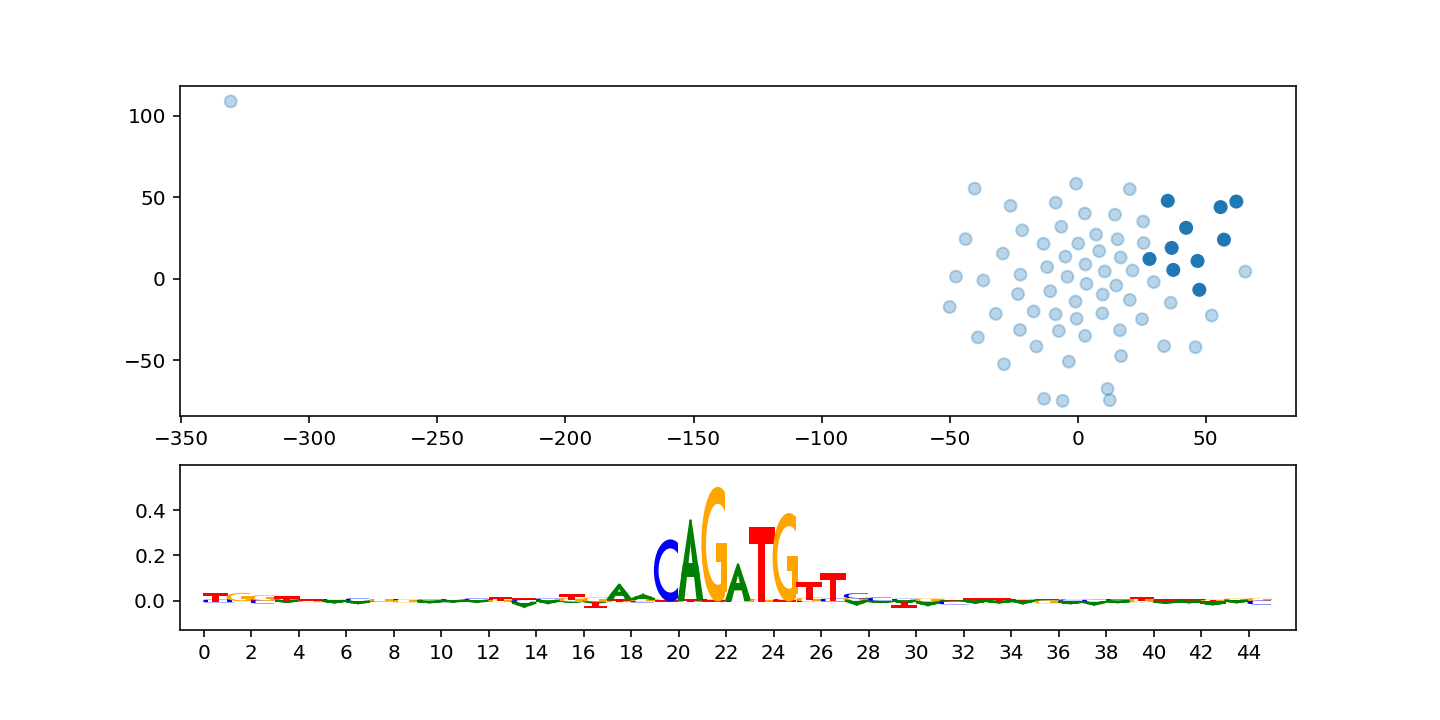

In [77]:
import modisco.visualization
reload(modisco.visualization)
reload(modisco.visualization.interactive)

modisco.visualization.interactive.make_interactive_plot(
    pattern=pattern,
    track_names_and_signs=[("task0_contrib_scores", 1)])